In [1]:
!pip install opencv-python numpy ultralytics matplotlib -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 15.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 21.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 17.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.4/802.4 kB 17.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 MB 22.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.2
    Uninstalling numpy-2.3.2:
      Successfully uninstalled numpy-2.3.2


Loading YOLOv8 model...
检测第 1 张图片：test_bike.jpg

0: 544x640 1 bicycle, 44.9ms
Speed: 2.7ms preprocess, 44.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)
检测结果图片保存至: /root/autodl-tmp/detected_result_test_bike.jpg


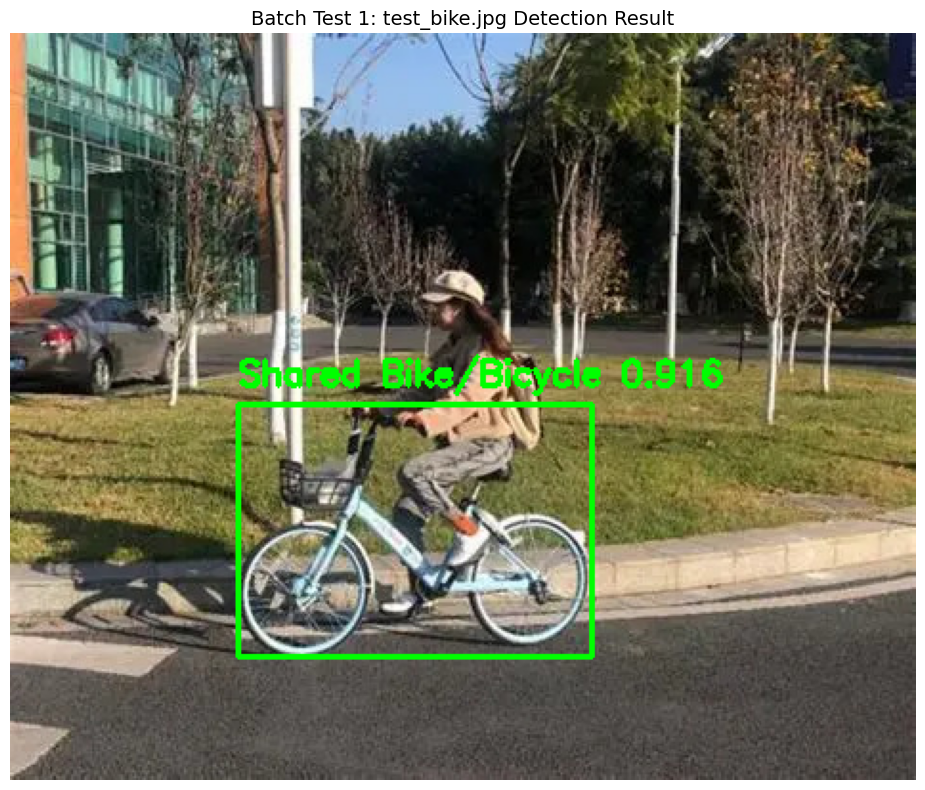


检测结果（位置坐标）:
序号   左上角x1       左上角y1       右下角x2          右下角y2          置信度       
--------------------------------------------------------------------------------
1    119         194         304            326            0.916     
--------------------------------------------------------------------------------
检测第 2 张图片：bike_3.jpg

0: 640x480 1 bicycle, 46.0ms
Speed: 3.1ms preprocess, 46.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)
检测结果图片保存至: /root/autodl-tmp/detected_result_bike_3.jpg


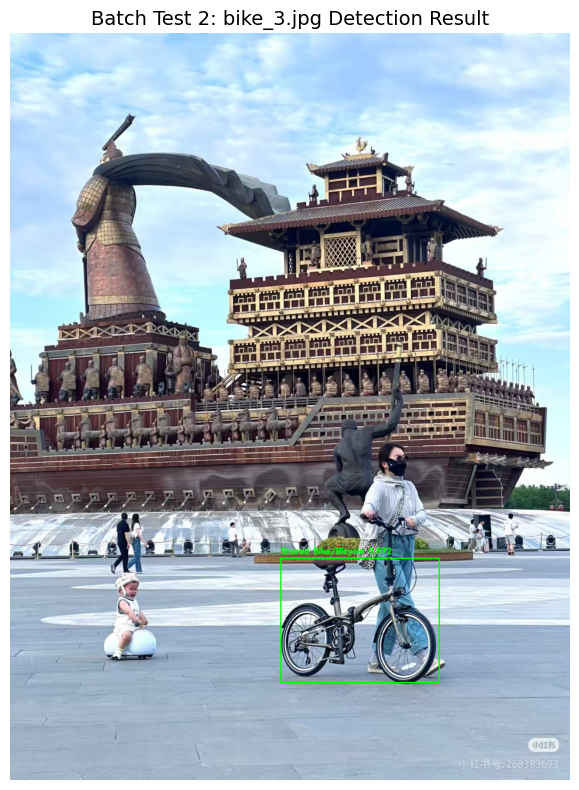


检测结果（位置坐标）:
序号   左上角x1       左上角y1       右下角x2          右下角y2          置信度       
--------------------------------------------------------------------------------
1    618         1199        980            1483           0.872     
--------------------------------------------------------------------------------

 所有图片批量检测完成！


In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')  

# 类别
TARGET_CLASS = 'Shared Bike/Bicycle'
CLASS_ID = 1  
TEST_IMAGE_PATHS = [
    'test_bike.jpg',  
    'bike_3.jpg',   
]

MODEL_NAME = 'yolov8n.pt'
CONFIDENCE_THRESHOLD = 0.5


def detect_shared_bike_single(image_path, model):
    
    if not os.path.exists(image_path):
        print(f"图片未找到: {image_path}")
        return [], None
    
    img = cv2.imread(image_path)
    if img is None:
        print(f"图片读取失败: {image_path}")
        return [], None
    
    img_copy = img.copy()  
    img_rgb = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)  
    
    results = model(img_copy, classes=[CLASS_ID], conf=CONFIDENCE_THRESHOLD)
    

    bike_positions = []  
    for r in results:
        boxes = r.boxes
        for box_idx, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = round(float(box.conf[0]), 3)  
            bike_positions.append([box_idx+1, x1, y1, x2, y2, confidence])
            
            
            cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)  
            label = f"{TARGET_CLASS} {confidence}"
            cv2.putText(img_copy, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    return bike_positions, img_copy

def detect_shared_bike_batch(image_paths):
    print("Loading YOLOv8 model...")
    model = YOLO(MODEL_NAME)
    

    for idx, image_path in enumerate(image_paths, 1):
        print(f"检测第 {idx} 张图片：{image_path}")

        bike_positions, labeled_img = detect_shared_bike_single(image_path, model)
        
        if labeled_img is None:
            continue  
        
        
        img_name = os.path.basename(image_path).split('.')[0]  
        output_img_path = f'detected_result_{img_name}.jpg' 
        cv2.imwrite(output_img_path, labeled_img)
        print(f"检测结果图片保存至: {os.path.abspath(output_img_path)}")
        
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(labeled_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')  
        plt.title(f'Batch Test {idx}: {os.path.basename(image_path)} Detection Result', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        
        print("\n检测结果（位置坐标）:")
        print(f"{'序号':<5}{'左上角x1':<12}{'左上角y1':<12}{'右下角x2':<15}{'右下角y2':<15}{'置信度':<10}")
        print("-"*80)
        if bike_positions:
            for pos in bike_positions:
                print(f"{pos[0]:<5}{pos[1]:<12}{pos[2]:<12}{pos[3]:<15}{pos[4]:<15}{pos[5]:<10}")
        else:
            print("未检测到共享单车！")
        print("-"*80)

if __name__ == "__main__":
    try:
        detect_shared_bike_batch(TEST_IMAGE_PATHS)
        print("\n 所有图片批量检测完成！")
        
    except Exception as e:
        print(f"\n 程序出错: {e}")